In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, recall_score, confusion_matrix, roc_curve
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Load dữ liệu
DATA_PATH = 'Data/Superstore.csv'
data = pd.read_csv(DATA_PATH, encoding='ISO-8859-1')

print("📊 Thông tin dữ liệu gốc:")
print(f"Shape: {data.shape}")
print(f"\nCác cột: {data.columns.tolist()}")
display(data.head())

📊 Thông tin dữ liệu gốc:
Shape: (9994, 21)

Các cột: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## 1.  Dựa trên các đặc trưng giao dịch, liệu chúng ta có thể xây dựng hệ thống cảnh báo sớm để tự động phát hiện các đơn hàng 'Rủi ro' trước khi duyệt không? Các yếu tố nào là tín hiệu cảnh báo mạnh nhất?

### A. Preprocessing

1.  **Tạo biến mục tiêu (`Risk_Flag`):** Chúng ta định nghĩa lại vấn đề:
    * **Class 1 (Rủi ro):** Các đơn hàng có `Profit < 0`.
    * **Class 0 (An toàn):** Các đơn hàng có `Profit >= 0`.
2.  **Chọn lọc đặc trưng (Feature Selection):**
    * Giữ lại các biến tác động trực tiếp: `Discount`, `Sales`, `Quantity`.
    * Giữ lại các thông tin ngữ cảnh: `Ship Mode`, `Segment`, `Category`, `Sub-Category`, `Region`.
    * Loại bỏ các biến định danh không có giá trị dự báo (`Row ID`, `Customer Name`, `Order ID`).
3.  **Mã hóa dữ liệu (Encoding):** Sử dụng *One-Hot Encoding* để chuyển đổi các biến phân loại (chữ) thành dạng số (0 và 1).
4.  **Chia tập dữ liệu:** Tách dữ liệu thành tập huấn luyện (80%) và tập kiểm thử (20%), sử dụng `stratify` để đảm bảo tỷ lệ đơn hàng Rủi ro được phân bố đều ở cả hai tập.

In [12]:
from sklearn.preprocessing import StandardScaler

data_2 = data.copy()
# 1. Tạo biến mục tiêu (Risk Flag)
# Nếu Profit < 0 thì gán nhãn 1 (Rủi ro), ngược lại là 0
data_2['Risk_Flag'] = (data_2['Profit'] < 0).astype(int)

# 2. Chọn đặc trưng (Features)
features_numerical = ['Discount', 'Sales', 'Quantity']
features_categorical = ['Ship Mode', 'Segment', 'Category', 'Sub-Category', 'Region']

# Tạo X (Features) và y (Target)
X = data_2[features_numerical + features_categorical]
y = data_2['Risk_Flag']

# 3. Mã hóa dữ liệu (One-Hot Encoding) 
X_encoded = pd.get_dummies(X, columns=features_categorical, drop_first=True)

# 4. Chia tập Train/Test (80/20) 
# Stratify=y giúp giữ nguyên tỷ lệ rủi ro giữa 2 tập
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Đã xử lý xong dữ liệu!")
print(f"- Kích thước tập Train: {X_train.shape}")
print(f"- Kích thước tập Test: {X_test.shape}")
print(f"- Tỷ lệ đơn hàng Rủi ro (Lớp 1): {y.mean()*100:.2f}%")

Đã xử lý xong dữ liệu!
- Kích thước tập Train: (7995, 29)
- Kích thước tập Test: (1999, 29)
- Tỷ lệ đơn hàng Rủi ro (Lớp 1): 18.72%


### B. Analysis

**1. Thiết lập bài toán:**

* **Mục tiêu ($y$):** Dự đoán nhãn `Risk_Flag` (biến phân loại nhị phân).
    * Giá trị $1$: Đơn hàng **Rủi ro** (Lợi nhuận $< 0$).
    * Giá trị $0$: Đơn hàng **An toàn** (Lợi nhuận $\ge 0$).
* **Đầu vào ($X$):** Các đặc trưng đơn hàng như `Discount`, `Quantity`, `Sales` và các biến phân loại (`Category`, `Region`...) đã được mã hóa One-Hot ở bước A.
* **Chia dữ liệu:** Tập dữ liệu được chia theo tỷ lệ **80% Huấn luyện (Training)** và **20% Kiểm thử (Testing)**.

**2. Lựa chọn mô hình:**

Chúng ta sẽ xây dựng và so sánh hai mô hình phân loại, cả hai đều sử dụng tham số `class_weight='balanced'` để xử lý vấn đề mất cân bằng dữ liệu (số lượng đơn lỗ ít hơn đơn lãi):

* **Logistic Regression (Hồi quy Logistic):**
    * Được chọn làm **mô hình cơ sở (baseline)**.
    * **Ưu điểm:** Cấu trúc đơn giản, minh bạch. Các hệ số của mô hình giúp ta giải thích trực tiếp chiều hướng tác động: Ví dụ, hệ số dương của `Discount` sẽ xác nhận giả thuyết rằng tăng chiết khấu làm tăng xác suất rủi ro.

* **Random Forest Classifier (Rừng ngẫu nhiên):**
    * Được chọn làm **mô hình chính**.
    * **Ưu điểm:** Khả năng nắm bắt các mối quan hệ **phi tuyến tính** và tương tác phức tạp giữa các biến (ví dụ: *Giảm giá cao chỉ gây lỗ nặng khi kết hợp với mặt hàng Bàn ghế*). Ngoài ra, mô hình này cung cấp tính năng `Feature Importance` để xếp hạng các yếu tố cảnh báo rủi ro hàng đầu.

**3. Đánh giá:**

* **Chỉ số Recall (Độ nhạy) của lớp 1:** Đây là thước đo quan trọng nhất cho bài toán quản trị rủi ro. Mục tiêu là tối đa hóa Recall để hệ thống không bỏ sót các đơn hàng có khả năng gây lỗ (giảm thiểu False Negatives).
* **Confusion Matrix (Ma trận nhầm lẫn):** Được sử dụng để trực quan hóa chi tiết số lượng đơn hàng rủi ro thực tế mà mô hình đã phát hiện đúng so với số lượng bị bỏ qua.

In [13]:
# Khởi tạo mô hình
# Logistic Regression: Tăng max_iter để đảm bảo hội tụ
log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Random Forest: Sử dụng 100 cây quyết định
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)

# Huấn luyện mô hình
print("Đang huấn luyện Logistic Regression...")
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

print("Đang huấn luyện Random Forest...")
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("Huấn luyện hoàn tất!")

Đang huấn luyện Logistic Regression...
Đang huấn luyện Random Forest...
Huấn luyện hoàn tất!


### C. Results & Interpretation

### C.1. Đánh giá Hiệu suất Tổng quan (Performance Metrics)

In [5]:
# Dự báo trên tập kiểm thử
y_pred_log = log_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# In báo cáo phân loại
print("--- 📊 LOGISTIC REGRESSION REPORT ---")
print(classification_report(y_test, y_pred_log))

print("\n" + "="*50 + "\n")

print("--- 🌲 RANDOM FOREST REPORT ---")
print(classification_report(y_test, y_pred_rf))

--- 📊 LOGISTIC REGRESSION REPORT ---
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1625
           1       0.71      0.96      0.82       374

    accuracy                           0.92      1999
   macro avg       0.85      0.94      0.88      1999
weighted avg       0.94      0.92      0.92      1999



--- 🌲 RANDOM FOREST REPORT ---
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1625
           1       0.87      0.81      0.84       374

    accuracy                           0.94      1999
   macro avg       0.91      0.89      0.90      1999
weighted avg       0.94      0.94      0.94      1999



Dựa trên báo cáo phân loại (Classification Report), chúng ta có sự so sánh rõ ràng giữa hai mô hình:

1.  **Logistic Regression (Mô hình Hồi quy):**
    * **Ưu điểm:** Đạt chỉ số **Recall cho lớp Rủi ro (1) rất cao: 0.96**. Điều này có nghĩa là mô hình bắt được **96%** tổng số đơn hàng bị lỗ, gần như không bỏ sót rủi ro nào.
    * **Nhược điểm:** Precision chỉ đạt **0.71**, nghĩa là có khá nhiều đơn hàng "An toàn" bị báo nhầm là "Rủi ro" (Báo động giả).

2.  **Random Forest (Mô hình Rừng ngẫu nhiên):**
    * **Ưu điểm:** Hiệu suất cân bằng và ổn định hơn hẳn. **Accuracy đạt 94%** (so với 92% của Logistic). Chỉ số **F1-score** cho lớp rủi ro đạt **0.84** (cao hơn mức 0.82 của Logistic).
    * **Đánh giá:** Mặc dù Recall (0.81) thấp hơn Logistic Regression, nhưng Precision lại cao hơn đáng kể (0.87).

**Kết luận chọn mô hình:**
Chúng ta chọn **Random Forest** làm mô hình cuối cùng để triển khai. Lý do là mô hình này cung cấp độ tin cậy cao hơn (Precision 0.87), giúp bộ phận duyệt đơn không bị "ngợp" bởi các báo động giả, trong khi vẫn duy trì khả năng phát hiện được **81%** các trường hợp thua lỗ.

### C.2. Phân tích Lỗi qua Confusion Matrix và đánh giá khả năng phân loại bằng ROC-Curve

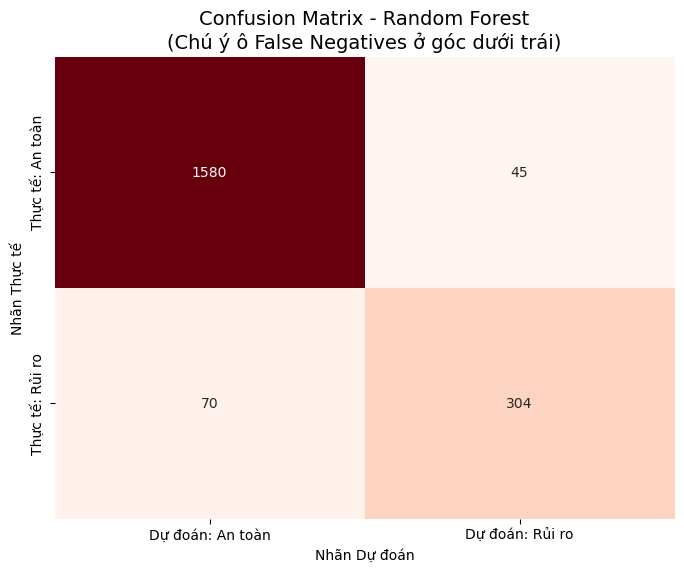

In [6]:
# Tính toán Confusion Matrix cho Random Forest
cm = confusion_matrix(y_test, y_pred_rf)

# Vẽ biểu đồ Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, 
            xticklabels=['Dự đoán: An toàn', 'Dự đoán: Rủi ro'],
            yticklabels=['Thực tế: An toàn', 'Thực tế: Rủi ro'])

plt.title('Confusion Matrix - Random Forest\n(Chú ý ô False Negatives ở góc dưới trái)', fontsize=14)
plt.ylabel('Nhãn Thực tế')
plt.xlabel('Nhãn Dự đoán')
plt.show()

# fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues', ax=axes[0])
# axes[0].set_title('Logistic Regression')
# axes[0].set_xlabel('Predicted')
# axes[0].set_ylabel('Actual')

# sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens', ax=axes[1])
# axes[1].set_title('Random Forest')
# axes[1].set_xlabel('Predicted')
# axes[1].set_ylabel('Actual')

# plt.tight_layout()

Phân tích sâu hơn vào kết quả của mô hình được chọn (**Random Forest**):

* **Khả năng phát hiện (Recall = 0.81):** Với tập kiểm thử có **374** đơn hàng bị lỗ thực tế, mô hình đã dự báo đúng phần lớn trong số đó. Việc bỏ sót 19% còn lại có thể do các nguyên nhân ngoại lai (chi phí vận chuyển đột biến hoặc các yếu tố dữ liệu chưa ghi nhận được).
* **Độ tin cậy cảnh báo (Precision = 0.87):** Khi hệ thống cảnh báo "Đơn hàng này rủi ro", có tới **87%** khả năng dự đoán đó là chính xác. Điều này giúp nhân viên vận hành tin tưởng vào khuyến nghị của hệ thống AI.

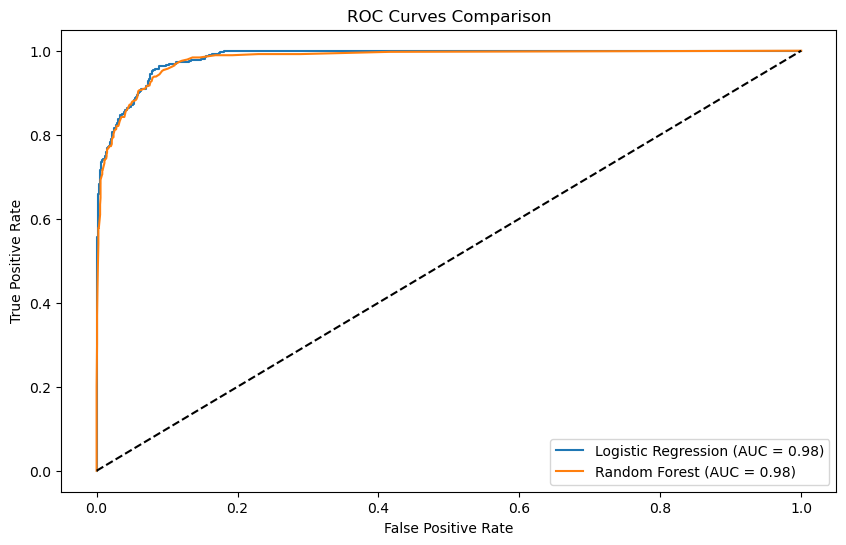

In [7]:
# ROC Curves
plt.figure(figsize=(10, 6))
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_log):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

Trục tung (True Positive Rate - Sensitivity): Tỷ lệ đơn Lỗ được phát hiện đúng.

Mong muốn: Càng cao càng tốt. Bạn muốn bắt trọn mọi đơn hàng gây lỗ để chặn lại.

Trục hoành (False Positive Rate - 1-Specificity): Tỷ lệ đơn Lãi bị báo nhầm thành Lỗ (Báo động giả).

Đường cong ROC cho thấy hiệu suất dự đoán của mô hình cực kỳ xuất sắc (AUC = 0.98) có thể dự đoán tốt các sản phẩm có nguy cơ lỗ khi trước khi kinh doanh.

### C.3. Giải thích Mô hình: Yếu tố nào dẫn đến thua lỗ?

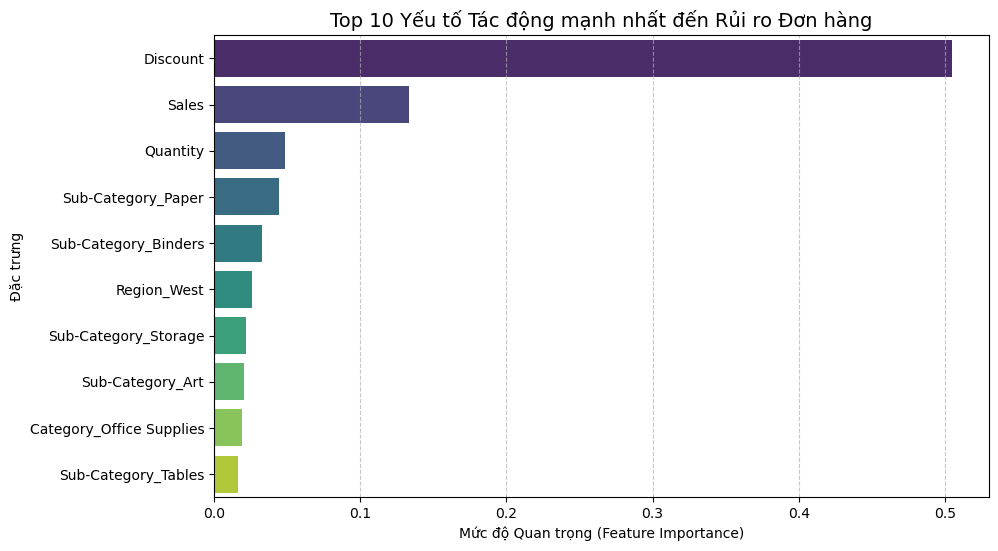

In [8]:
# Lấy độ quan trọng của các đặc trưng
importances = rf_model.feature_importances_
feature_names = X_encoded.columns

# Tạo DataFrame để dễ sắp xếp
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(10) # Lấy Top 10

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_imp_df, palette='viridis')

plt.title('Top 10 Yếu tố Tác động mạnh nhất đến Rủi ro Đơn hàng', fontsize=14)
plt.xlabel('Mức độ Quan trọng (Feature Importance)')
plt.ylabel('Đặc trưng')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Kết quả phân tích dữ liệu xác nhận rằng **Mức chiết khấu (Discount)** là yếu tố tử huyệt phân định giữa "Lãi" và "Lỗ". Số liệu thực tế cho thấy sự chênh lệch khổng lồ:

* Mức chiết khấu trung bình của đơn hàng **RỦI RO**: **48.09%**.
* Mức chiết khấu trung bình của đơn hàng **AN TOÀN**: **8.14%**.

$\rightarrow$ **Nhận xét:** Nhóm đơn hàng bị lỗ có mức giảm giá cao gấp **5.9 lần** so với nhóm an toàn. Điều này khẳng định luật quyết định quan trọng nhất của mô hình: Khi Discount vượt quá một ngưỡng nhất định (thường là > 20%), xác suất rủi ro sẽ tăng phi mã.

### C.4. Kết luận & Kiến nghị Kinh doanh

In [9]:
# Phân tích nhanh để hỗ trợ kết luận (Ví dụ: So sánh Discount trung bình)
avg_discount_risky = data_2[data_2['Risk_Flag'] == 1]['Discount'].mean()
avg_discount_safe = data_2[data_2['Risk_Flag'] == 0]['Discount'].mean()

print(f"💡 THÔNG TIN BỔ SUNG:")
print(f"- Mức chiết khấu trung bình của đơn hàng RỦI RO: {avg_discount_risky:.2%}")
print(f"- Mức chiết khấu trung bình của đơn hàng AN TOÀN: {avg_discount_safe:.2%}")
print(f"-> Chênh lệch gấp {avg_discount_risky/avg_discount_safe:.1f} lần.")

💡 THÔNG TIN BỔ SUNG:
- Mức chiết khấu trung bình của đơn hàng RỦI RO: 48.09%
- Mức chiết khấu trung bình của đơn hàng AN TOÀN: 8.14%
-> Chênh lệch gấp 5.9 lần.


Từ kết quả thực nghiệm, chúng ta rút ra các kiến nghị hành động cụ thể để tối ưu hóa lợi nhuận:

1.  **Thiết lập "Chốt chặn" Chiết khấu:**
    * Dữ liệu cho thấy mức giảm giá **~48%** là vùng nguy hiểm chắc chắn lỗ. Doanh nghiệp cần thiết lập quy tắc trên hệ thống ERP: **Không cho phép nhân viên Sales nhập mức chiết khấu > 40%** nếu không có sự phê duyệt đặc biệt từ cấp quản lý.
    
2.  **Triển khai Hệ thống Cảnh báo sớm:**
    * Tích hợp mô hình **Random Forest** vào quy trình duyệt đơn.
    * Với độ chính xác 94%, hệ thống sẽ tự động phê duyệt các đơn hàng "Xanh" (An toàn) để đẩy nhanh tốc độ giao hàng, và chỉ giữ lại các đơn hàng "Đỏ" (Rủi ro) để con người kiểm tra lại.

3.  **Tối ưu hóa chiến dịch Marketing:**
    * Cần xem xét lại hiệu quả của các chương trình khuyến mãi giảm giá sâu (Deep Discount). Việc giảm giá tới 50-60% để đẩy doanh số (Volume) đang đánh đổi quá lớn về mặt lợi nhuận (Margin), dẫn đến thua lỗ thực tế.

## 2. Đâu là những "Hố đen tài chính" tại các thị trường trọng điểm? Cụ thể, nhóm sản phẩm (Sub-Category) nào tại các Tiểu bang đang có Doanh số cao nhưng Lợi nhuận âm?

### Phương pháp tiếp cận (Top-Down):
1.  **Macro View:** Xác định Top 10 Tiểu bang có tổng lợi nhuận thấp nhất.
2.  **Micro View:** Đi sâu vào các tiểu bang này để tìm ra các danh mục sản phẩm gây lỗ (High Sales - Negative Profit).

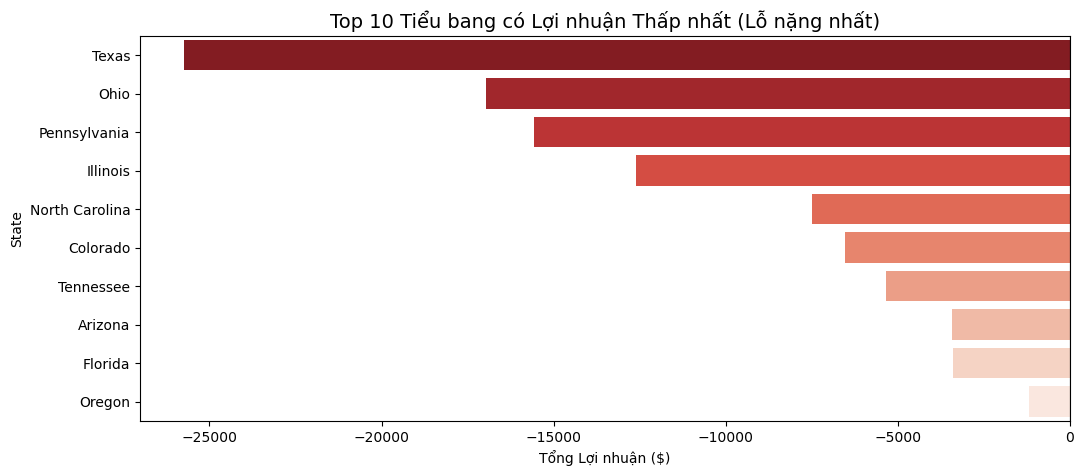

3 'Hố đen' lớn nhất cần điều tra ngay lập tức: ['Texas', 'Ohio', 'Pennsylvania']


In [10]:
# --- XÁC ĐỊNH "HỐ ĐEN" CẤP TIỂU BANG ---

# Tính tổng lợi nhuận theo từng Bang và sắp xếp tăng dần
state_profit = data.groupby('State')['Profit'].sum().sort_values().head(10)

# Trực quan hóa Top 10 Bang lỗ nặng nhất
plt.figure(figsize=(12, 5))
sns.barplot(x=state_profit.values, y=state_profit.index, hue=state_profit.index, palette='Reds_r')
plt.title('Top 10 Tiểu bang có Lợi nhuận Thấp nhất (Lỗ nặng nhất)', fontsize=14)
plt.xlabel('Tổng Lợi nhuận ($)')
plt.axvline(0, color='black', linewidth=0.8) # Đường kẻ mốc 0
plt.show()

# In ra danh sách 3 bang tệ nhất để phân tích tiếp
worst_states = state_profit.index[:3].tolist()
print(f"3 'Hố đen' lớn nhất cần điều tra ngay lập tức: {worst_states}")

**Nhận xét:**
Biểu đồ trên chỉ ra rằng **Texas, Ohio, và Pennsylvania** là 3 thị trường gây thất thoát lợi nhuận lớn nhất.  
*Câu hỏi đặt ra:* Tại các bang này, chúng ta đang bán cái gì mà lỗ? Liệu có phải do bán ế không, hay do bán nhiều nhưng chiết khấu sai?

Ta thử lọc dữ liệu chỉ lấy 3 bang này và vẽ biểu đồ tương quan giữa Doanh số (Sales) và Lợi nhuận (Profit) theo từng Danh mục phụ (Sub-Category).

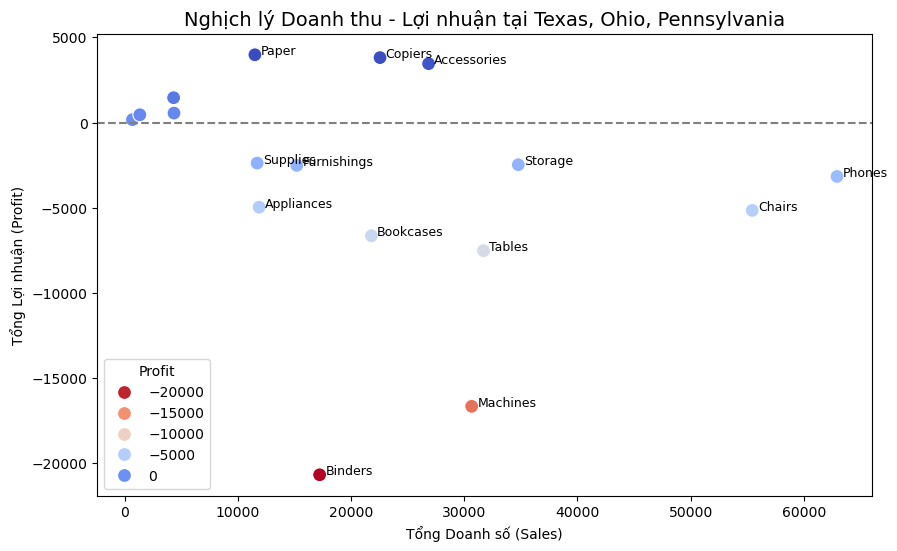

In [11]:
# --- PHÂN TÍCH SÂU VÀO CÁC BANG BỊ LỖ ---

# 1. Lọc dữ liệu của 3 bang lỗ nhất
df_loss = data[data['State'].isin(worst_states)]

# 2. Tổng hợp theo Sub-Category (Tính tổng Sales và Profit)
sub_analysis = df_loss.groupby('Sub-Category')[['Sales', 'Profit']].sum().reset_index()

# 3. Vẽ biểu đồ phân tán (Scatter Plot) để tìm "Nghịch lý"
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sub_analysis, x='Sales', y='Profit', hue='Profit', s=100, palette='coolwarm_r')

# Trang trí biểu đồ
plt.axhline(0, color='gray', linestyle='--') # Đường hòa vốn
plt.title(f'Nghịch lý Doanh thu - Lợi nhuận tại {", ".join(worst_states)}', fontsize=14)
plt.xlabel('Tổng Doanh số (Sales)')
plt.ylabel('Tổng Lợi nhuận (Profit)')

# Gắn nhãn tên sản phẩm cho các điểm nổi bật (Lỗ nặng hoặc Doanh số cao)
for i in range(sub_analysis.shape[0]):
    # Chỉ gắn nhãn nếu Doanh số > 10000 hoặc Lỗ < -2000 để đỡ rối mắt
    if sub_analysis.Sales[i] > 10000 or sub_analysis.Profit[i] < -2000:
        plt.text(sub_analysis.Sales[i]+500, sub_analysis.Profit[i], 
                 sub_analysis['Sub-Category'][i], fontsize=9)

plt.show()

**Kết luận & Kiến nghị Chiến lược**

**A. Nhận xét cụ thể (Key Observations):**

Dựa vào biểu đồ phân tán "Nghịch lý Doanh thu - Lợi nhuận", ta thấy rõ sự phân hóa hiệu suất tại 3 thị trường trọng điểm (**Texas, Ohio, Pennsylvania**):

1.  **Nhận diện "Hố đen" (Góc dưới bên phải):**
    * Hai danh mục **Binders** (Văn phòng phẩm) và **Machines** (Máy móc) đang rơi vào tình trạng *"Bẫy Doanh số" (Sales Trap)*.
    * **Cụ thể:** Doanh số bán ra rất cao (nằm ở phía bên phải trục hoành) nhưng Lợi nhuận lại âm sâu (phía dưới trục tung).
2.  **Nguyên nhân cốt lõi:**
    * Việc doanh số cao chứng tỏ nhu cầu thị trường là có thật và rất lớn.
    * Tuy nhiên, lợi nhuận âm cho thấy **Chiến lược giá (Pricing Strategy)** đang thất bại. Khả năng cao nhân viên kinh doanh tại các bang này đang lạm dụng quyền giảm giá (Discount) quá đà để chốt đơn, dẫn đến việc biên lợi nhuận bị ăn mòn hoàn toàn, thậm chí thâm hụt vào vốn.

**B. Kiến nghị Hành động (Actionable Recommendations):**

Thay vì cắt bỏ hoàn toàn (có thể làm mất thị phần), chúng ta cần điều chỉnh thông minh:

1.  **Thiết lập "Trần Chiết khấu" (Discount Ceiling) cục bộ:**
    * Ban hành quy định mới riêng cho Texas/Ohio: **Không được phép giảm giá quá 20%** đối với nhóm hàng *Binders* và *Machines*. Mọi ngoại lệ cần phê duyệt cấp cao. Điều này giúp "cầm máu" ngay lập tức mà vẫn duy trì được sự hiện diện trên thị trường.

2.  **Chiến lược Bán chéo (Bundling Strategy):**
    * Thay vì giảm giá trực tiếp vào *Machines* (mặt hàng đang lỗ), hãy giữ nguyên giá và tặng kèm các sản phẩm có biên lợi nhuận cao (High Margin) như *Paper* (Giấy) hoặc *Labels* (Nhãn). Cách này giúp khách hàng cảm thấy có hời nhưng tổng lợi nhuận đơn hàng vẫn dương.

3.  **Tái phân bổ ngân sách Marketing:**
    * Dừng ngay các chiến dịch quảng cáo cho *Tables* và *Machines* tại 3 bang này.
    * Dồn ngân sách đó để đẩy mạnh **Phones** và **Copiers** – hai danh mục thường nằm ở góc "Trên phải" (Doanh số cao, Lời nhiều) để gánh vác chỉ tiêu lợi nhuận cho toàn khu vực.